In [1]:
pip install pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 28.4 MB/s eta 0:00:00


In [2]:
import requests
import csv
from io import StringIO
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from pulp import LpMinimize, LpProblem, LpVariable, lpSum

**1) Demostrar que el Hitting-Set Problem está en NP.**

Se dice que un problema está en NP si existe un algoritmo polinómico que verifica soluciones propuestas. En el caso del Hitting-Set Problem, una solución propuesta es un conjunto C, y queremos verificar si C es efectivamente una solución del problema, es decir, interseca cada conjunto Bi.

La verificación se puede hacer de la siguiente manera:
1. Para cada conjunto Bi:
  - Verificar si la intersección entre C y Bi es no vacía.
  - Esto se puede hacer en tiempo lineal, ya que el tamaño de C y Bi es finito y conocido.
2. Si la intersección es no vacía para todos los conjuntos Bi, entonces C es una solución del Hitting-Set Problem.

El proceso de verificación se puede realizar en timepo polinómico, ya que estamos realizando una operación constante (verificar la intersección de C) para cada uno de los conjuntos Bi.

---

**2) Demostrar que el Hitting-Set Problem es NP-Completo**

Se dice que un problema es NP-Completo si pertenece a NP y cualquier problema en NP se puede reducir polinómicamente a él. Resolver eficientemente un problema NP-Completo implicaría resolver eficientemente todos los problemas en NP.

Para probar la NP-Completitud vamos a demostrar que el Vertex Cover Problem se puede reducir a el Hitting-Set Problem.

Pero antes, recordemos de que trata el ***Vertex Cover Problem***:

- Dado un grafo no dirigido G = (V, E), un Vertex Cover es un conjunto C de vértices tal que cada arista en E tiene al menos un extremo en C.
- El problema es decidir si existe un Vertex Cover de tamño k para un k dado.

Procedemos entonces con la demostración de la reducción del Vertex Cover Problem al Hitting-Set Problem:

Dado un grafo G = (V, E) en el problema Vertex Cover, construimos una instancia equivalente del Hitting-Set Problem:
- **Conjunto de elementos A**: será el conjunto de vértices V del grafo.
- **Subconjuntos Bi**: por cada arista (u, v) en el grafo, creamos un conjunto Bi en el Hitting-Set Problem que contiene los vertices u y v.

Verificación de la Reducción:
- Si existe un Vertex Cover C en G de tamaño k, entonces para una arista (u, v), u o v pertenece a C. Por lo tanto, C conforma el Hitting Set ya que cada subconjunto Bi tiene al menos un elemento en común con C.
- Si existe un Hitting-Set C' en A, entonces C' interseca todos los subconjuntos de A. Por lo tanto, como C' cubre al menos una arista de cada vértice de G, C' conforma un Vertex Cover en G.

Ejemplo:

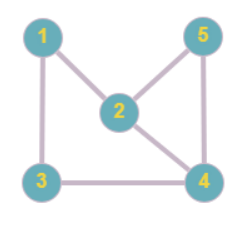

Si G tiene vértices {1, 2, 3, 4, 5} y aristas {(1, 2), (1, 3), (2, 4), (2, 5), (3, 4)}, la construcción equivalente en el Hitting-Set Problem sería:
- A = {1, 2, 3, 4, 5}
- B1 = {1, 2}
- B2 = {1, 3}
- B3 = {2, 4}
- B4 = {2, 5}
- B5 = {3, 4}

Un Vertex Cover C de tamaño k = 3 en G es C = {1, 2, 4} ya que al menos un extremo de cada arista está contenido en C. Como estos vértices cubren todas las aristas y los subconjuntos Bi de A están conformados por los vértices de las aristas, entonces C es un Hitting Set en A.

A su vez, un Hitting-Set C' de tamaño k = 3 en A es C' = {1, 2, 4} ya que al menos un elemento de cada subconjunto Bi está contenido en C'. Como los subconjuntos Bi están formados por las aristas (u, v), y u o v pertenecen a C', entonces C' es un Vertex Cover en G.

---

**3) Escribir un algoritmo que, por backtracking, obtenga la solución óptima al problema.**

In [3]:
import csv

def get_jugadores_from_csv(url):
  response = requests.get(url)
  lines = response.text.splitlines()
  lines = lines[1:]

  jugadores = set()
  for line in lines:
    jugadores.add(line)
  return jugadores

In [4]:
def get_jugadores_pedidos_from_txt(url, res):

    response = requests.get(url)
    lines = response.text.splitlines()

    jugadores = set()

    pedidos_prensa = [line.strip().split(',') for line in lines]
    for conjunto in pedidos_prensa:
        for jugador in conjunto:
            jugadores.add(jugador)

    return (list(jugadores), pedidos_prensa, res)


In [5]:
test_cases = {}

In [6]:
# conjuntos_# = (jugadores, pedidos_prensa,)
test_cases["conjuntos_5"] = get_jugadores_pedidos_from_txt('https://raw.githubusercontent.com/gabokatta/TDA-2C2023/main/TP3/casos_prueba/5.txt', 2)
test_cases["conjuntos_7"] = get_jugadores_pedidos_from_txt('https://raw.githubusercontent.com/gabokatta/TDA-2C2023/main/TP3/casos_prueba/7.txt', 2)
test_cases["conjuntos_10_pocos"] = get_jugadores_pedidos_from_txt('https://raw.githubusercontent.com/gabokatta/TDA-2C2023/main/TP3/casos_prueba/10_pocos.txt', 3)
test_cases["conjuntos_10_varios"] = get_jugadores_pedidos_from_txt('https://raw.githubusercontent.com/gabokatta/TDA-2C2023/main/TP3/casos_prueba/10_varios.txt', 6)
test_cases["conjuntos_10_todos"] = get_jugadores_pedidos_from_txt('https://raw.githubusercontent.com/gabokatta/TDA-2C2023/main/TP3/casos_prueba/10_todos.txt', 10)
test_cases["conjuntos_15"] = get_jugadores_pedidos_from_txt('https://raw.githubusercontent.com/gabokatta/TDA-2C2023/main/TP3/casos_prueba/15.txt', 4)
test_cases["conjuntos_20"] = get_jugadores_pedidos_from_txt('https://raw.githubusercontent.com/gabokatta/TDA-2C2023/main/TP3/casos_prueba/20.txt', 5)
test_cases["conjuntos_50"] = get_jugadores_pedidos_from_txt('https://raw.githubusercontent.com/gabokatta/TDA-2C2023/main/TP3/casos_prueba/50.txt', 6)
test_cases["conjuntos_75"] = get_jugadores_pedidos_from_txt('https://raw.githubusercontent.com/gabokatta/TDA-2C2023/main/TP3/casos_prueba/75.txt', 8)
test_cases["conjuntos_100"] = get_jugadores_pedidos_from_txt('https://raw.githubusercontent.com/gabokatta/TDA-2C2023/main/TP3/casos_prueba/100.txt', 9)
test_cases["conjuntos_200"] = get_jugadores_pedidos_from_txt('https://raw.githubusercontent.com/gabokatta/TDA-2C2023/main/TP3/casos_prueba/200.txt', 9)

In [7]:
#Set de Nombres
sample_jugadores = get_jugadores_from_csv("https://raw.githubusercontent.com/gabokatta/TDA-2C2023/main/TP3/casos_prueba/nombres.csv")

## Algoritmo de Backtracking

In [ ]:
# jugadores: Lista de Jugadores
# indice_jugador: Indice del jugador que se esta evaluando actualmente.
# pedidos: Lista de pedidos de la prensa
# seleccion_actual: solucion temporaria
# seleccion_final: solucion final
def seleccion_backtracking(jugadores, indice_jugador, pedidos, seleccion_actual, seleccion_final):
    if not pedidos:
        if len(seleccion_actual) < len(seleccion_final):
            seleccion_final = seleccion_actual.copy()
        return seleccion_final

    for i in range(indice_jugador, len(jugadores)):

        if len(seleccion_actual) + 1 >= len(seleccion_final):
            break

        jugador_actual = jugadores[i]
        if jugador_actual not in seleccion_actual:
            seleccion_actual.add(jugador_actual)
            nuevos_pedidos = [conjunto for conjunto in pedidos if jugador_actual not in conjunto]
            seleccion_final = seleccion_backtracking(jugadores, i + 1 , nuevos_pedidos, seleccion_actual, seleccion_final)
            seleccion_actual.remove(jugador_actual)

    return seleccion_final

In [ ]:
  # Aplicamos ordenamientos a casos de prueba de la materia.
  for name, test in test_cases.items():
    print(f'Test con {name}\n')

    seleccion = (test[0], test[1])
    start_time = time.time()
    seleccion_final = seleccion_backtracking(test[0], 0 ,test[1], set(), set(test[0]))
    total_time = time.time() - start_time

    status_message = "\x1b[32mPASSED\x1b[0m" if test[2] == len(seleccion_final) else "\x1b[31mFAILED\x1b[0m"
    print(f'EXPECTED: {test[2]} --- RESULT: {len(seleccion_final)} --- STATUS: {status_message} --- TIME: {total_time:.6f} seg\n')

  print("-------------------------------------------------------------")

Test con conjuntos_5

EXPECTED: 2 --- RESULT: 2 --- STATUS: PASSED --- TIME: 0.000052 seg

Test con conjuntos_7

EXPECTED: 2 --- RESULT: 2 --- STATUS: PASSED --- TIME: 0.000216 seg

Test con conjuntos_10_pocos

EXPECTED: 3 --- RESULT: 3 --- STATUS: PASSED --- TIME: 0.001189 seg

Test con conjuntos_10_varios

EXPECTED: 6 --- RESULT: 6 --- STATUS: PASSED --- TIME: 0.429568 seg

Test con conjuntos_10_todos

EXPECTED: 10 --- RESULT: 10 --- STATUS: PASSED --- TIME: 99.480591 seg

Test con conjuntos_15

EXPECTED: 4 --- RESULT: 4 --- STATUS: PASSED --- TIME: 0.019585 seg

Test con conjuntos_20

EXPECTED: 5 --- RESULT: 5 --- STATUS: PASSED --- TIME: 0.361728 seg

Test con conjuntos_50

EXPECTED: 6 --- RESULT: 6 --- STATUS: PASSED --- TIME: 1.987822 seg

Test con conjuntos_75

EXPECTED: 8 --- RESULT: 8 --- STATUS: PASSED --- TIME: 20.402882 seg

Test con conjuntos_100

EXPECTED: 9 --- RESULT: 9 --- STATUS: PASSED --- TIME: 53.558264 seg

Test con conjuntos_200

EXPECTED: 9 --- RESULT: 9 --- STA

**4) Algoritmo de Programación Lineal**

Variables de decisión:

Sea x_i igual a 1 si el jugador i es seleccionado y 0 de lo contrario.

x_i ∈ {0, 1}

Función Objetivo:

Minimizar la cantidad total de jugadores seleccionados. Esto se puede expresar como:

Min ∑ x_i

Restricciones:

Cada conjunto debe estar cubierto. Si un conjunto está cubierto, al menos un jugador de ese conjunto debe ser seleccionado. Esto se puede expresar como:

∑ x_i ≥ 1, i ∈ Conjunto_j, para cada conjunto j

In [15]:
def seleccionar_pl(jugadores, pedidos_prensa):
    prob = LpProblem("SeleccionJugadores", LpMinimize)

    x = {jugador: LpVariable(name=f"x_{jugador}", cat="Binary") for jugador in jugadores}

    prob += lpSum(x[jugador] for jugador in jugadores)

    for conjunto in pedidos_prensa:
        prob += lpSum(x[jugador] for jugador in conjunto) >= 1

    prob.solve()

    seleccion_final = {jugador: int(x[jugador].value()) for jugador in jugadores}
    return [player for player in seleccion_final.keys() if seleccion_final[player] == 1]

In [ ]:
resultados_test_pl = {}
for name, test in test_cases.items():
  print(f'Test con {name}\n')

  seleccion = (test[0], test[1])
  start_time = time.time()
  seleccion_final = seleccionar_pl(test[0], test[1])
  total_time = time.time() - start_time

  #Guardamos resultados
  resultados_test_pl[name] = len(seleccion_final)

  status_message = "\x1b[32mPASSED\x1b[0m" if test[2] == len(seleccion_final) else "\x1b[31mFAILED\x1b[0m"
  print(f'EXPECTED: {test[2]} --- RESULT: {len(seleccion_final)} --- STATUS: {status_message} --- TIME: {total_time:.6f} seg\n')

  print("-------------------------------------------------------------")

Test con conjuntos_5

EXPECTED: 2 --- RESULT: 2 --- STATUS: PASSED --- TIME: 0.009789 seg

-------------------------------------------------------------
Test con conjuntos_7

EXPECTED: 2 --- RESULT: 2 --- STATUS: PASSED --- TIME: 0.010966 seg

-------------------------------------------------------------
Test con conjuntos_10_pocos

EXPECTED: 3 --- RESULT: 3 --- STATUS: PASSED --- TIME: 0.013739 seg

-------------------------------------------------------------
Test con conjuntos_10_varios

EXPECTED: 6 --- RESULT: 6 --- STATUS: PASSED --- TIME: 0.011808 seg

-------------------------------------------------------------
Test con conjuntos_10_todos

EXPECTED: 10 --- RESULT: 10 --- STATUS: PASSED --- TIME: 0.012401 seg

-------------------------------------------------------------
Test con conjuntos_15

EXPECTED: 4 --- RESULT: 4 --- STATUS: PASSED --- TIME: 0.017384 seg

-------------------------------------------------------------
Test con conjuntos_20

EXPECTED: 5 --- RESULT: 5 --- STAT

**5) Algoritmo de aproximación**

Variables de decisión:

Sea x_i ∈ [0, 1]

Función Objetivo:

Minimizar la cantidad total de jugadores seleccionados. Esto se puede expresar como:

Min ∑ x_i

Restricciones:

Cada conjunto debe estar cubierto. Si un conjunto está cubierto, al menos un jugador de ese conjunto debe ser seleccionado. Esto se puede expresar como:

∑ x_i ≥ 1, i ∈ Conjunto_j, para cada conjunto j

Redondeo:

Para redondear, obtenemos el valor b como la longitud del pedido de prensa con mayor cantidad de jugadores, y definimos que la variables de decisión de cada jugador serán 1 si su valor en el modelo relajado es mayor o igual a 1/b.

Cálculo de r(A):





In [14]:
from pulp import LpProblem, LpVariable, lpSum, LpMinimize

def seleccionar_aproximado(jugadores, pedidos_prensa):
    prob = LpProblem("SeleccionJugadores", LpMinimize)

    x = {jugador: LpVariable(name=f"x_{jugador}", lowBound=0, upBound=1) for jugador in jugadores}

    prob += lpSum(x[jugador] for jugador in jugadores)

    for conjunto in pedidos_prensa:
        prob += lpSum(x[jugador] for jugador in conjunto) >= 1

    prob.solve()

    b = max(len(conjunto) for conjunto in pedidos_prensa)
    for jugador in jugadores:
        valor_relajado = x[jugador].value()
        x[jugador].value = 1 if valor_relajado >= 1 / b else 0

    seleccion_final = {jugador: int(x[jugador].value) for jugador in jugadores}
    return [player for player in seleccion_final.keys() if seleccion_final[player] == 1]


In [ ]:
resultados_test_aprox = {}
for name, test in test_cases.items():
  print(f'Test con {name}\n')

  seleccion = (test[0], test[1])
  start_time = time.time()
  seleccion_final = seleccionar_aproximado(test[0], test[1])
  total_time = time.time() - start_time

  resultados_test_aprox[name] = len(seleccion_final)

  status_message = "\x1b[32mPASSED\x1b[0m" if test[2] == len(seleccion_final) else "\x1b[31mFAILED\x1b[0m"
  print(f'EXPECTED: {test[2]} --- RESULT: {len(seleccion_final)} --- STATUS: {status_message} --- TIME: {total_time:.6f} seg\n')

  print("-------------------------------------------------------------")

Test con conjuntos_5

EXPECTED: 2 --- RESULT: 2 --- STATUS: PASSED --- TIME: 0.009267 seg

-------------------------------------------------------------
Test con conjuntos_7

EXPECTED: 2 --- RESULT: 2 --- STATUS: PASSED --- TIME: 0.009632 seg

-------------------------------------------------------------
Test con conjuntos_10_pocos

EXPECTED: 3 --- RESULT: 6 --- STATUS: FAILED --- TIME: 0.009600 seg

-------------------------------------------------------------
Test con conjuntos_10_varios

EXPECTED: 6 --- RESULT: 6 --- STATUS: PASSED --- TIME: 0.009650 seg

-------------------------------------------------------------
Test con conjuntos_10_todos

EXPECTED: 10 --- RESULT: 10 --- STATUS: PASSED --- TIME: 0.009258 seg

-------------------------------------------------------------
Test con conjuntos_15

EXPECTED: 4 --- RESULT: 11 --- STATUS: FAILED --- TIME: 0.010609 seg

-------------------------------------------------------------
Test con conjuntos_20

EXPECTED: 5 --- RESULT: 12 --- ST

In [ ]:
# Ordenamiento Greedy por Frecuencia de aparicion en los pedidos
def sort_jugadores_por_frecuencia(pedidos):
    freq = {}
    for conjunto in pedidos:
        for jugador in conjunto:
            freq[jugador] = freq.get(jugador, 0) + 1
    return sorted(freq.keys(), key=lambda jugador: freq[jugador], reverse=True)


In [ ]:
# Algoritmo Greedy
def seleccion_greedy(prensa):

    seleccion_final = set()
    jugadores_ordenados = sort_jugadores_por_frecuencia(prensa)

    for jugador in jugadores_ordenados:

      if not prensa:
        break

      pedidos_pendientes = [pedido for pedido in prensa if jugador in pedido]
      if pedidos_pendientes:
        seleccion_final.add(jugador)
        prensa = [pedido for pedido in prensa if jugador not in pedido]

    return seleccion_final

In [ ]:
resultados_test_greedy = {}
for name, test in test_cases.items():
  print(f'Test con {name}\n')

  seleccion = (test[0], test[1])
  start_time = time.time()
  seleccion_final = seleccion_greedy(test[1])
  total_time = time.time() - start_time

  #Guardamos resultados
  resultados_test_greedy[name] = len(seleccion_final)

  status_message = "\x1b[32mPASSED\x1b[0m" if test[2] == len(seleccion_final) else "\x1b[31mFAILED\x1b[0m"
  print(f'EXPECTED: {test[2]} --- RESULT: {len(seleccion_final)} --- STATUS: {status_message} --- TIME: {total_time:.6f} seg\n')

  print("-------------------------------------------------------------")

Test con conjuntos_5

EXPECTED: 2 --- RESULT: 2 --- STATUS: PASSED --- TIME: 0.000039 seg

-------------------------------------------------------------
Test con conjuntos_7

EXPECTED: 2 --- RESULT: 3 --- STATUS: FAILED --- TIME: 0.000049 seg

-------------------------------------------------------------
Test con conjuntos_10_pocos

EXPECTED: 3 --- RESULT: 4 --- STATUS: FAILED --- TIME: 0.000043 seg

-------------------------------------------------------------
Test con conjuntos_10_varios

EXPECTED: 6 --- RESULT: 8 --- STATUS: FAILED --- TIME: 0.000061 seg

-------------------------------------------------------------
Test con conjuntos_10_todos

EXPECTED: 10 --- RESULT: 10 --- STATUS: PASSED --- TIME: 0.000071 seg

-------------------------------------------------------------
Test con conjuntos_15

EXPECTED: 4 --- RESULT: 5 --- STATUS: FAILED --- TIME: 0.000063 seg

-------------------------------------------------------------
Test con conjuntos_20

EXPECTED: 5 --- RESULT: 6 --- STAT

# Graficos

In [11]:
def extract_jugadores(pedidos):
  jugadores = set()
  for pedido in pedidos:
    for jugador in pedido:
      jugadores.add(jugador)
  return list(jugadores)

In [10]:
def seleccionar_ejecucion(jugadores, pedidos, modo):
  if modo == 'backtracking':
    return seleccion_backtracking(jugadores, 0, pedidos, set(), set(jugadores))
  if modo == 'PL':
    return seleccionar_pl(jugadores, pedidos)
  if modo =='PL-APROX':
    return seleccionar_aproximado(jugadores, pedidos)
  if modo == 'greedy':
    return seleccion_greedy(pedidos)

In [12]:
import math
# N siendo la cantidad de pedidos que querramos
def generate_pedidos(n_pedidos):
    cantidad_jugadores = math.ceil(n_pedidos * 1.20)
    jugadores = random.sample(list(sample_jugadores), k=cantidad_jugadores)
    new_pedidos = []
    for i in range(n_pedidos):
        pedido_size = random.randint(1, (cantidad_jugadores//2))
        selected = set(random.sample(jugadores, k=pedido_size))
        new_pedidos.append(selected)
    return new_pedidos

In [ ]:
import time

def prueba_volumen(casos, modos):
  tiempos = {modo: [] for modo in modos}
  for modo in tqdm(modos):
    print(f"\n\nMODO: {modo}")
    for caso in tqdm(casos):
      pedidos = generate_pedidos(caso)
      jugadores = extract_jugadores(pedidos)
      start = time.time()
      seleccionar_ejecucion(jugadores, pedidos, modo)
      stop = time.time()
      tiempo_ejecucion = (stop - start) * 1000
      tiempos[modo].append(tiempo_ejecucion)

  return casos, tiempos

In [ ]:
# Realiza la prueba de volumen para los de PL y Greedy
n_elementos, mediciones = prueba_volumen(list(range(10, 1500)), ['PL', 'PL-APROX', 'greedy'])

  0%|          | 0/3 [00:00<?, ?it/s]



MODO: PL



 33%|███▎      | 1/3 [26:49<53:38, 1609.20s/it]



MODO: PL-APROX



 67%|██████▋   | 2/3 [35:04<15:54, 954.22s/it] 



MODO: greedy



100%|██████████| 3/3 [36:22<00:00, 727.51s/it]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def suavizar_datos(datos, ventana=35):
    suavizado = np.convolve(datos, np.ones(ventana)/ventana, mode='valid')
    print(len(suavizado))
    padding_izquierdo = np.full((ventana-1)//2, datos[0])
    padding_derecho = np.full((ventana-1)//2 + len(datos) % 2, datos[-1])
    return np.concatenate((padding_izquierdo, suavizado, padding_derecho))

def graficar_datos_suavizados(n_elementos, mediciones, ventana=35):
    for caso, tiempos in mediciones.items():
        tiempos_suavizados = suavizar_datos(tiempos, ventana)
        len(tiempos_suavizados)
        plt.plot(n_elementos[:len(tiempos_suavizados)], tiempos_suavizados, label=caso)


    plt.xlabel('Número de Elementos')
    plt.ylabel('Tiempo de Ejecución (ms)')
    plt.title(f'Prueba de Volumen con Suavizado (Ventana={ventana})')
    plt.legend()
    plt.grid(True)
    plt.show()


1456
1456
1456


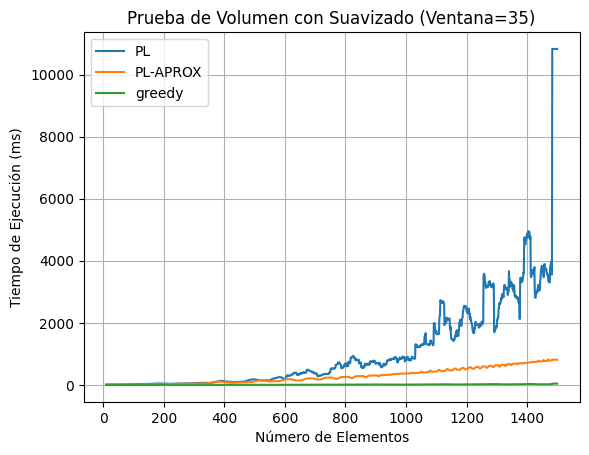

In [ ]:
graficar_datos_suavizados(n_elementos, mediciones)

In [ ]:
# Para backtracking
n_elementos_backtracking, mediciones_backtracking = prueba_volumen(list(range(10, 100)), ['backtracking'])

  0%|          | 0/1 [00:00<?, ?it/s]



MODO: backtracking



100%|██████████| 1/1 [00:13<00:00, 13.98s/it]


81


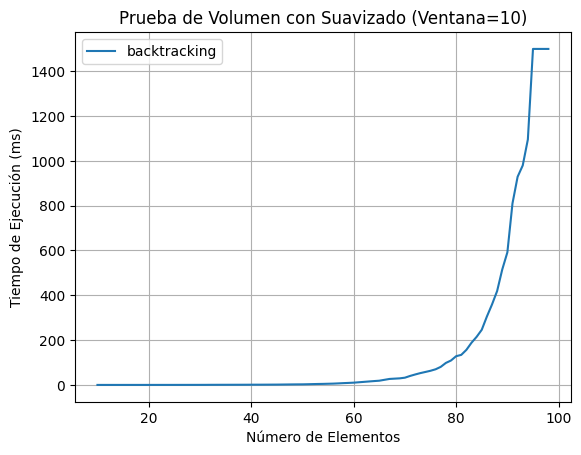

In [ ]:
graficar_datos_suavizados(n_elementos_backtracking, mediciones_backtracking, 10)

In [ ]:
algoritmos = ["PL", "PL-APROX", "greedy"]

In [ ]:
resultados = {algoritmo: [] for algoritmo in algoritmos}
resultados['b'] = []
prueba_cotas(5000,10)

100%|██████████| 500/500 [09:32<00:00,  1.15s/it]


In [ ]:
valores_n = list(range(5, 5000,10))
plt.figure(figsize=(20, 6))
plt.plot(valores_n, resultados['PL'], label='PL')
plt.plot(valores_n, resultados['PL-APROX'], label='PL-APROX ')
plt.plot(valores_n, resultados['greedy'], label='Greedy')

# Personalizar la gráfica
plt.title('Diferencias entre Greedy, PL-APROX y PL')
plt.xlabel('N (Tamaño del conjunto de datos)')
plt.ylabel('Resultados de Seleccion')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
def prueba_cota(archivos):
  relacion = []
  lista_b = []
  casos = []
  for caso, (jugadores, pedidos, res) in tqdm(archivos.items()):
    casos.append(caso)
    b = len(max(pedidos, key=len))
    lista_b.append(b)
    jugadores = extract_jugadores(pedidos)
    result_PL = len(seleccionar_ejecucion(jugadores, pedidos, "PL"))
    result_APROX = len(seleccionar_ejecucion(jugadores, pedidos, 'PL-APROX'))
    relacion.append(result_APROX/result_PL)

  return casos, relacion ,lista_b

In [45]:
# Realiza la prueba de volumen para los de PL y Greedy
casos, relacion ,lista_b = prueba_cota(test_cases)

100%|██████████| 11/11 [00:03<00:00,  3.26it/s]


In [52]:
def graficar_resultados(casos, relacion, lista_b):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(casos, relacion, label='Relacion A(I)/Z(I)', marker='o', color='blue')
    ax.plot(casos, lista_b, label='R(A) = b', marker='s', color='green')

    ax.set_xlabel('Casos')
    ax.set_ylabel('Valores')
    ax.set_title('Resultados de Cotas con ')
    ax.legend()

    plt.xticks(casos, rotation=30)

    # Mostrar la gráfica
    plt.show()

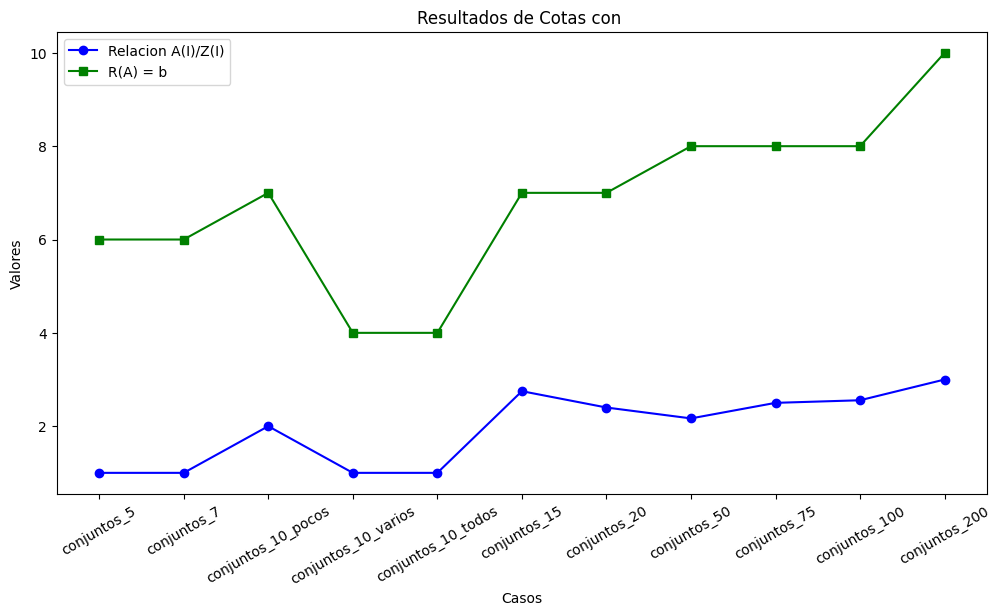

In [53]:
graficar_resultados(casos, relacion ,lista_b)